# Creating VAE in keras to generate molecules

In [1]:
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.layers import Input, Dense, LSTM, Lambda, Reshape, TimeDistributed, Convolution1D, Flatten, GRU, BatchNormalization
from keras.models import Model
from keras import objectives
from keras.layers.core import RepeatVector
from keras.losses import MSE
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, History

Using TensorFlow backend.


In [2]:
latent_dim = 292
inter_dim = 501
max_smiles_len = 120

In [3]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

In [4]:
def smiles_to_onehot(smiles, max_len = max_smiles_len):
    onehot = np.zeros((max_len, len(SMILES_CHARS)))
    onehot[0, smi2index['!']] = 1
    for i, c in enumerate(smiles):
        onehot[i+1, smi2index[c]] = 1
    return onehot


def smiles_decoder(onehot):
    smi = ''
    onehot = onehot.argmax( axis=-1 )
    for i in onehot:
        smi += index2smi[i]
    return smi

In [14]:
smiles_decoder(smiles_to_onehot(df.smiles.iloc[0]))

'!CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1                                                                                '

## Training data

### Zinc dataset

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('250k_rndm_zinc_drugs_clean_3.csv')

In [9]:
SMILES_CHARS = set()
for smile in df.smiles.tolist():
    set_smile = set(smile)
    SMILES_CHARS = SMILES_CHARS.union(set_smile)

SMILES_CHARS = list(SMILES_CHARS)
SMILES_CHARS.insert(0,' ')
SMILES_CHARS.insert(1,'!')

num_smiles_chars =  len(SMILES_CHARS)
num_smiles_chars

input_dim = (max_smiles_len, num_smiles_chars)
output_dim = (max_smiles_len, num_smiles_chars)


smi2index = dict((c, i) for i, c in enumerate(SMILES_CHARS))
index2smi = dict((i, c) for i, c in enumerate(SMILES_CHARS))

smi2index['\n'] = smi2index[' ']

In [10]:
X_all = np.array(df.smiles.apply(lambda x: smiles_to_onehot(x)).tolist())

In [11]:
del df

In [12]:
X =  X_all[:225000]

In [13]:
X_val = X_all[225000:]

### Smaller datasets

In [87]:
X =  X_all[:40000]

In [88]:
X_val = X_all[-2000:]

### Dataset from unknown source

In [1]:
with open('smiles.txt') as f:
    full_smiles_as_list = f.readlines()
    
SMILES_CHARS = set()
for smile in full_smiles_as_list:
    set_smile = set(smile)
    SMILES_CHARS = SMILES_CHARS.union(set_smile)

SMILES_CHARS = list(SMILES_CHARS)
SMILES_CHARS.insert(0,' ')
SMILES_CHARS.insert(1,'!')

num_smiles_chars =  len(SMILES_CHARS)

input_dim = (max_smiles_len, num_smiles_chars)
output_dim = (max_smiles_len, num_smiles_chars)


smi2index = dict((c, i) for i, c in enumerate(SMILES_CHARS))
index2smi = dict((i, c) for i, c in enumerate(SMILES_CHARS))

Using TensorFlow backend.


In [6]:
X_all = [smiles_to_onehot(x) for x in full_smiles_as_list]
X_all = np.array(X_all)
X_all.shape

(115936, 120, 36)

In [7]:
X = X_all[:100000]

In [8]:
X = X_all[:10000]
X.shape

(10000, 120, 36)

In [28]:
X_val = X_all[-2000:]

### Segedfuggvenyek

In [23]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

## Loss functions

In [22]:
def calculate_loss(x, x_decoded):
    x = K.flatten(x)
    x_decoded = K.flatten(x_decoded)
    recon = max_smiles_len * objectives.binary_crossentropy(x, x_decoded)

    
    kl = 0.5 * K.sum(K.exp(z_var) + K.square(z_mean) - 1. - z_var,axis = -1)
    #kl *= 0.1
    return recon + kl

In [9]:
def z_loss(x, x_new):
    #xent_loss = objectives.mse(x, x_new)
    kl_loss = 0.5 * K.mean(1 + z_var - K.square(z_mean) - K.exp(z_var),axis=-1)
    # loss = kl_loss + xent_loss
    return kl_loss

## Possible improvements <br>
- more lstm layers <br>
- lstm layer larger output dim <br>
- to avoid posteior collapse problem give less weight to KL loss

## Model of the encoder

### 2 LSTM layer

In [9]:
x_input = Input(shape=input_dim)
lstm = LSTM(inter_dim, return_sequences=True)(x_input)
lstm_inter = LSTM(inter_dim)(lstm)
z_mean = Dense(latent_dim)(lstm_inter)
z_var = Dense(latent_dim)(lstm_inter)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_var])
encoder = Model(x_input, z)

### Convolutional networks

In [16]:
x_input = Input(shape=input_dim)
h = Convolution1D(9, 9, activation = 'relu', name='conv_1')(x_input)
h = Convolution1D(9, 9, activation = 'relu', name='conv_2')(h)
h = Convolution1D(10, 11, activation = 'relu', name='conv_3')(h)
h = Flatten(name='flatten_1')(h)
h = Dense(435, activation = 'relu', name='dense_1')(h)

z_mean = Dense(latent_dim, name='z_mean')(h)
z_var = Dense(latent_dim, name='z_log_var')(h)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_var])
encoder = Model(x_input, z)

### Simple network

In [67]:
x_input = Input(shape=input_dim)
lstm = LSTM(inter_dim)(x_input)
z_mean = Dense(latent_dim)(lstm)
z_var = Dense(latent_dim)(lstm)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_var])
encoder = Model(x_input, z)

## Model of the decoder

### 2 LSTM Layers

In [112]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
h = Dense(latent_dim, activation = 'relu', name='dense_1')(h)
repeated = RepeatVector(max_smiles_len)(latent_inputs)
hidden_lstm = LSTM(inter_dim, return_sequences=True)(repeated)
hidden_lstm = LSTM(inter_dim, return_sequences=True)(hidden_lstm)
hidden_lstm = LSTM(inter_dim, return_sequences=True)(hidden_lstm)
x_2 = TimeDistributed(Dense(num_smiles_chars, activation='softmax'), name='decoded_mean')(hidden_lstm)

decoder = Model(latent_inputs, x_2)

### GRU layers

In [17]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
h = Dense(latent_dim, name='latent_input', activation = 'relu')(latent_inputs)
h = RepeatVector(max_smiles_len, name='repeat_vector')(h)
h = GRU(inter_dim, return_sequences = True, name='gru_1')(h)
h = GRU(inter_dim, return_sequences = True, name='gru_2')(h)
h = GRU(inter_dim, return_sequences = True, name='gru_3')(h)
x_2 = TimeDistributed(Dense(num_smiles_chars, activation='softmax'), name='decoded_mean')(h)

decoder = Model(latent_inputs, x_2)

### SImple 1 lstm decoder

In [68]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
repeated = RepeatVector(max_smiles_len)(latent_inputs)
hidden_lstm = LSTM(inter_dim, return_sequences=True)(repeated)
x_2 = TimeDistributed(Dense(num_smiles_chars, activation='softmax'), name='decoded_mean')(repeated)

decoder = Model(latent_inputs, x_2)

## Testing the decoder

In [21]:
decoder.compile(loss=MSE, optimizer='adam')

In [24]:
Y = np.zeros((10000,292))

In [25]:
decoder.fit(Y, X, epochs=1, batch_size=100)

Epoch 1/1
 1400/10000 [===>..........................] - ETA: 2:10 - loss: 0.0109

KeyboardInterrupt: 

In [26]:
test_input = np.zeros((3,292))

In [27]:
result = decoder.predict(test_input)

In [28]:
result.shape

(3, 100, 35)

## Testing the encoder

In [29]:
encoder.compile(loss=calculate_loss, optimizer='adam')

In [31]:
encoder.fit(X, X, epochs=10, batch_size=1)

Epoch 1/10


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv_1_1/convolution (defined at C:\Users\ivani\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]] [Op:__inference_keras_scratch_graph_15343]

Function call stack:
keras_scratch_graph


In [26]:

X1 = X[0:1]
X1 = np.reshape(X1, (1,100,57))

In [27]:
vec = encoder.predict(X1)
vec

array([[-8.1301773e-01, -2.6299402e-01, -9.8160648e-01, -1.2278748e+00,
        -1.1572304e+00, -1.5604430e+00, -1.3140545e+00, -7.6917696e-01,
        -2.4372327e+00,  1.0624061e+00, -3.0992565e-01,  8.3419043e-01,
         5.6062818e-01, -1.3172098e-01, -9.5717466e-01, -2.1324940e+00,
         5.0561869e-01,  2.7011657e-01,  5.0852150e-01, -1.7143270e+00,
         8.7156326e-01,  7.9136580e-01,  2.8402200e-01,  1.1757556e+00,
        -6.0712612e-01,  2.3732959e-01,  1.5342817e+00,  8.8119239e-01,
         1.3047813e+00, -7.7862233e-01, -1.4512120e-03,  1.3836908e-01,
        -1.2058165e+00, -1.8850985e+00, -7.6009864e-01, -1.7057220e+00,
        -1.0867665e+00, -1.8097383e+00,  1.2657901e+00, -2.4245261e-01,
         1.1391633e+00,  5.5728078e-01, -1.2521151e-01,  3.1110209e-01,
         1.3163338e+00,  2.4253933e+00,  1.1826134e+00,  1.9561082e+00,
         9.5373905e-01, -4.7003338e-01,  1.5187393e+00, -1.9416742e-01,
        -3.8858828e-01,  3.5764900e-01, -8.0885172e-01,  1.90862

##  Compile VAE

In [18]:
x_2 = decoder(encoder(x_input))

In [19]:
vae = Model(x_input,x_2)

In [36]:
from keras.models import load_model
vae = load_model('VAE.h5', custom_objects={'calculate_loss': calculate_loss})

In [129]:
vae.compile(loss=calculate_loss, optimizer='Adam', metrics = ['accuracy'])

In [37]:
checkpointer = ModelCheckpoint(filepath = 'VAE.h5',
                               verbose = 1,
                               save_best_only = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              min_lr = 0.0001)

In [38]:
vae.fit(X,X, epochs=50, shuffle = True, batch_size=100,callbacks = [checkpointer, reduce_lr], validation_data=[X_val,X_val])

Train on 225000 samples, validate on 24455 samples
Epoch 1/50


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,120,37]
	 [[node input_1 (defined at C:\Users\ivani\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]]
	 [[input_11_8/_3]]
  (1) Invalid argument:  You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,120,37]
	 [[node input_1 (defined at C:\Users\ivani\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_keras_scratch_graph_22917]

Function call stack:
keras_scratch_graph -> keras_scratch_graph


In [18]:
import joblib
joblib.dump(vae,'vae.joblib')

['vae.joblib']

In [73]:
from matplotlib import pyplot as plt

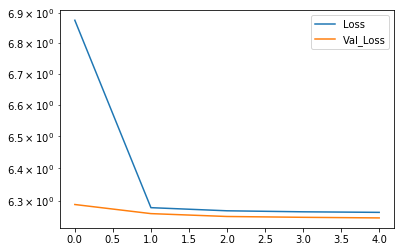

In [96]:
plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

In [29]:
X1 = X[:10]
X1 = np.reshape(X1, (10,120,37))

In [30]:
predicted = vae.predict(X1)

In [31]:
for ind in np.arange(0,predicted.shape[0]):
    print(smiles_decoder(predicted[ind]))

!888NNNNN88NNN88888NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN                      ]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]
!888NNNN/88NNN88888NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN                  ooo]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]
!888NNNNN88NNN88888NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN                     o]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]
!888NNNNN88NNN88888NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN                   oo]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]
!888NNNNN88NNN88888NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN                  ooooooo]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]
!888NNNNN88NNN88888NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN                  oooo]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]
!888NNNNN88NNN88888NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN                     o]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]
!888NNNNN88NNN88888NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN                    o]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]
!888NNNNN88NNN88888NNNNNNNNNNNNN

In [32]:
print(smiles_decoder(X1[-10]))
print(smiles_decoder(X1[-9]))
print(smiles_decoder(X1[-8]))
print(smiles_decoder(X1[-7]))

!CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1                                                                                
!C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1                                                                           
!N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)cc2)cc1                                                                  
!CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c2CCCCC3)C1                                                               


In [100]:
https://github.com/maxhodak/keras-molecules
    https://github.com/aksub99/molecular-vae/blob/master/Molecular_VAE.ipynb
        https://github.com/cxhernandez/molencoder
            https://github.com/topazape/molecular-VAE

SyntaxError: invalid syntax (<ipython-input-100-c844e9e44247>, line 1)